In [ ]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import time
import os

from utils.dictionaries import types_fleet_original,propulsion_mapping,mapping

# Pandas vs Polars comparison

### Using polars

In [2]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")

start_time = time.time()               
original_fleet_pl = pl.read_csv(original_fleet_path, separator='|', schema=types_fleet_original)
newest_matr = original_fleet_pl.select(pl.col("FECHA_MATR").max()).item()
elapsed_time = time.time() - start_time
print(f'The most recent registration is from the day {newest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most recent registration is from the day 2023-12-29
Elapsed time: 135.59454011917114


In [4]:
start_time = time.time()               
oldest_matr = original_fleet_pl.select(pl.col("FECHA_MATR").min()).item()
elapsed_time = time.time() - start_time
print(f'The most anitque registration is from the day {oldest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most anitque registration is from the day 1901-08-10
Elapsed time: 0.03117513656616211


### Using pandas

In [10]:
def reader(name, sep=',', columns=['FECHA_MATR'], parse_dates=None):
    chunksize = 10**4
    dates_col = parse_dates
    chunkreader = pd.read_csv(name, sep=sep, usecols=columns,chunksize=chunksize, 
                              on_bad_lines='skip', low_memory=False, parse_dates=dates_col) 
    #If bad lines not skipped we get an error bc of different types of data in the same columns
    #Columns (0,1,8,11,12,15,19,20,23,24,25,26,27,30,32,33,37,39,40,41,42,43,44) 

    for chunk in chunkreader:
        yield chunk

In [11]:
fechas = []
file = os.path.join(path,"Exact_fleet","mat_2023.txt")
start_time = time.time()
for chunk in reader(file,sep='|'):
    chunk['FECHA_MATR'] = pd.to_datetime(chunk['FECHA_MATR'], errors='coerce', dayfirst=True)
    fechas.append(chunk['FECHA_MATR'].max())

elapsed_time = time.time() - start_time
dates = pd.DataFrame({'NEWEST_MATR' : fechas})
newest_matr = dates['NEWEST_MATR'].max()
print(f'The most recent registration is from the day {newest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most recent registration is from the day 2023-12-29 00:00:00
Elapsed time: 269.78870701789856


In [12]:
fechas = []
file = os.path.join(path,"Exact_fleet","mat_2023.txt")
start_time = time.time()
for chunk in reader(file,sep='|'):
    chunk['FECHA_MATR'] = pd.to_datetime(chunk['FECHA_MATR'], errors='coerce', dayfirst=True)
    fechas.append(chunk['FECHA_MATR'].min())

elapsed_time = time.time() - start_time
dates = pd.DataFrame({'NEWEST_MATR' : fechas})
oldest_matr = dates['NEWEST_MATR'].min()
print(f'The most recent registration is from the day {oldest_matr}')
print(f"Elapsed time: {elapsed_time}")

The most recent registration is from the day 1901-08-10 00:00:00
Elapsed time: 302.4455111026764


# Visualization of different columns of interest

### TIPO_DISTINTIVO

In [51]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")
          
distintivo = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select('TIPO_DISTINTIVO')
distintivo = distintivo.collect()['TIPO_DISTINTIVO'].value_counts().sort('TIPO_DISTINTIVO')
distintivo

TIPO_DISTINTIVO,count
str,u32
"""CERO""",445184
"""DISTINTIVO B""",10494638
"""DISTINTIVO C""",13321998
"""ECO""",1403495
"""SIN DISTINTIVO""",12225546


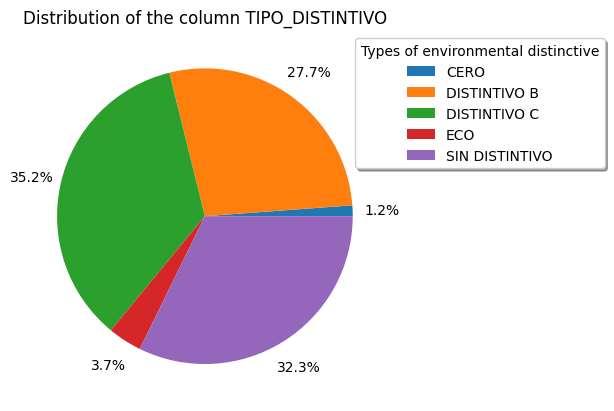

In [52]:
labels = distintivo['TIPO_DISTINTIVO'].to_list()
values = distintivo['count'].to_list()

fig, ax = plt.subplots()
ax.pie(values, autopct='%1.1f%%',
       pctdistance=1.2, labeldistance=0.6,startangle=0)

plt.legend(labels, title='Types of environmental distinctive',
           loc="upper right",  bbox_to_anchor=(1.1, 0, 0.5, 1),
           fancybox=True, shadow = True)
plt.title('Distribution of the column TIPO_DISTINTIVO')
output_path = os.path.join('..','Figures','Distribution_TIPO_DISTINTIVO.png')
plt.savefig(output_path, bbox_inches="tight")
plt.show()

### EMISIONES_CO2

In [41]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")
          
emisiones_co2 = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(['EMISIONES_CO2','FECHA_MATR'])
emisiones_co2 = emisiones_co2.collect()

In [37]:
null_perc = (100*emisiones_co2.select('EMISIONES_CO2').null_count()/emisiones_co2['EMISIONES_CO2'].len()).item()
print(f'{null_perc:.2f} % of this column is composed by null values')

52.91 % of this column is composed by null values


In [ ]:
null_co2 = emisiones_co2.filter(pl.col('EMISIONES_CO2').is_null())
not_null_CO2 = emisiones_co2.filter(pl.col('EMISIONES_CO2').is_not_null())

not_nulls = not_null_CO2.select('FECHA_MATR').get_columns()[0]
max_mat = not_nulls.max()
min_mat = not_nulls.min()

nulls = null_co2.select('FECHA_MATR').get_columns()[0]
max_mat2 = nulls.max()
min_mat2 = nulls.min()

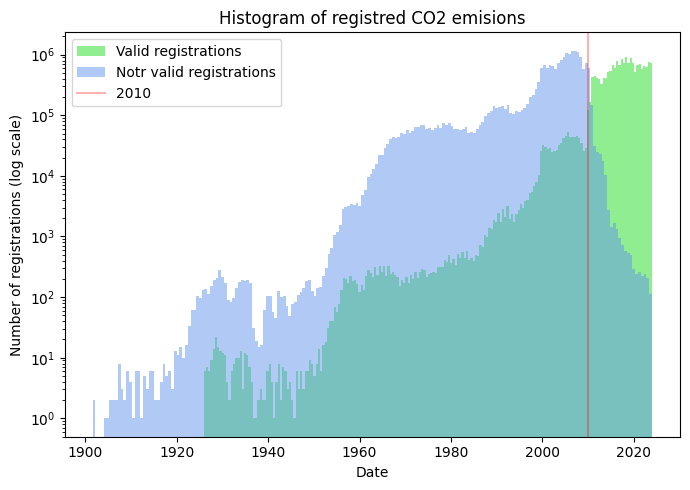

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(not_nulls,bins=200,range=(min_mat, max_mat),log=True,
    alpha=1,color="lightgreen",label="Valid registrations")

ax.hist(nulls,bins=200,range=(min_mat2, max_mat2),log=True,
    alpha=0.5,color="cornflowerblue",label="Not valid registrations")

ax.axvline(x=pd.Timestamp("2010-01-01"),color="red",alpha=0.3,label="2010")

ax.set_title("Histogram of registred CO2 emisions")
ax.set_xlabel("Date")
ax.set_ylabel("Number of registrations (log scale)")
ax.legend()

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONESCO2_hist_log.png')
plt.savefig(output_path)
plt.show()

### EMISIONES_EURO

In [3]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")       
# Columns that were explored 
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW','TARA','PESO_MAX']

complete_park = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(columns)
complete_park = complete_park.collect()

In [73]:
null_perc = (100*complete_park.select('EMISIONES_EURO').null_count()/complete_park['EMISIONES_EURO'].len()).item()
null_count = complete_park.select('EMISIONES_EURO').null_count().item()
print(f'{null_perc:.2f} % of this column is composed by null values')
print(f'That is equivalent to {null_count}')

12.65 % of this column is composed by null values
That is equivalent to 4792438


#### EMISIONES_EURO related with registration dates

In [ ]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")       
# Columns that were explored 
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW','TARA','PESO_MAX']

complete_park = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(columns)
complete_park = complete_park.collect()

In [ ]:
cols = ['EMISIONES_EURO','FECHA_MATR','FECHA_PRIM_MATR']
null_dataframe = complete_park.select(cols).filter(pl.col('EMISIONES_EURO').is_null())
not_null_dataframe = complete_park.select(cols).filter(pl.col('EMISIONES_EURO').is_not_null())

In [4]:
matricula = not_null_dataframe.select('FECHA_MATR').get_columns()[0]
max_mat = matricula.max()
min_mat = matricula.min()

prim_matricula = not_null_dataframe.select('FECHA_PRIM_MATR').get_columns()[0]
max_primmat = prim_matricula.max()
min_primmat = prim_matricula.min()

diff = matricula - prim_matricula
s_days = diff.cast(pl.Duration).dt.total_days().cast(pl.Int32)/365
min_diff = s_days.min()
max_diff = s_days.max()

matricula2 = null_dataframe.select('FECHA_MATR').get_columns()[0]
max_mat2 = matricula2.max()
min_mat2 = matricula2.min()

prim_matricula2 = null_dataframe.select('FECHA_PRIM_MATR').get_columns()[0]
max_primmat2 = prim_matricula2.max()
min_primmat2 = prim_matricula2.min()

diff2 = matricula2 - prim_matricula2
s_days2 = diff2.cast(pl.Duration).dt.total_days().cast(pl.Int32)/365
min_diff2 = s_days2.min()
max_diff2 = s_days2.max()

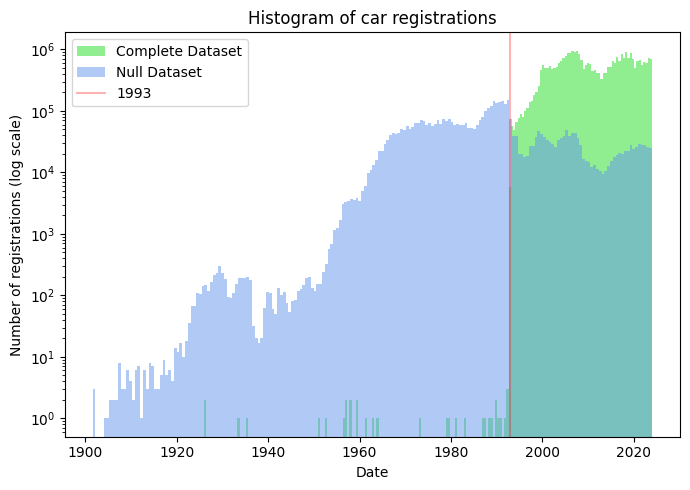

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(matricula,bins=200,range=(min_mat, max_mat),log=True,
    alpha=1,color="lightgreen",label="Complete Dataset")

ax.hist(matricula2,bins=200,range=(min_mat2, max_mat2),log=True,
    alpha=0.5,color="cornflowerblue",label="Null Dataset")

ax.axvline(x=pd.Timestamp("1993-01-01"),color="red",alpha=0.3,label="1993")

ax.set_title("Histogram of car registrations")
ax.set_xlabel("Date")
ax.set_ylabel("Number of registrations (log scale)")
ax.legend()

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_date.png')
plt.savefig(output_path)
plt.show()

#### EMISIONES_EURO related with CLASE_MATR

In [11]:
def bar_plot(dataframe, nombre_columna,titulo, ax=None, threshold= 0.25, color = 'cornflowerblue'):
    values = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column('count').to_list()
    values_labels = dataframe[nombre_columna].value_counts().sort('count', descending=True).get_column(nombre_columna).to_list()

    for i, label in enumerate(values_labels):
        if label is None:
            values_labels[i] = 'None'

    others = 0
    percentages, labels = [], []

    for i, value in enumerate(values):
        percentage = 100 * value / sum(values)
        if percentage < threshold:
            others += percentage
        else:
            percentages.append(percentage)
            labels.append(values_labels[i])

    if others > 0:
        percentages.append(others)
        labels.append('Others')

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))

    bars = ax.bar(labels, percentages, log=True, color = color)  
    
    ax.set_ylabel('Porcentage (log scale)')
    ax.set_title(titulo)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize = 12)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', 
                ha='center', va='bottom', fontsize=12)

    if ax is None:
        plt.show()

In [ ]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")       
# Columns that were explored 
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW','TARA','PESO_MAX']

complete_park = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(columns)
complete_park = complete_park.collect()

complete_park = complete_park.with_columns(
    pl.col('CLASE_MATR').replace(mapping['CLASE_MATR']).alias("CLASE_MATR"),
    pl.col('SUBTIPO_DGT').replace(mapping['SUBTIPO_DGT']).alias("SUBTIPO_DGT"),
    pl.col('PROPULSION').replace(propulsion_mapping).alias("PROPULSION"))

null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_null())

not_null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_not_null())

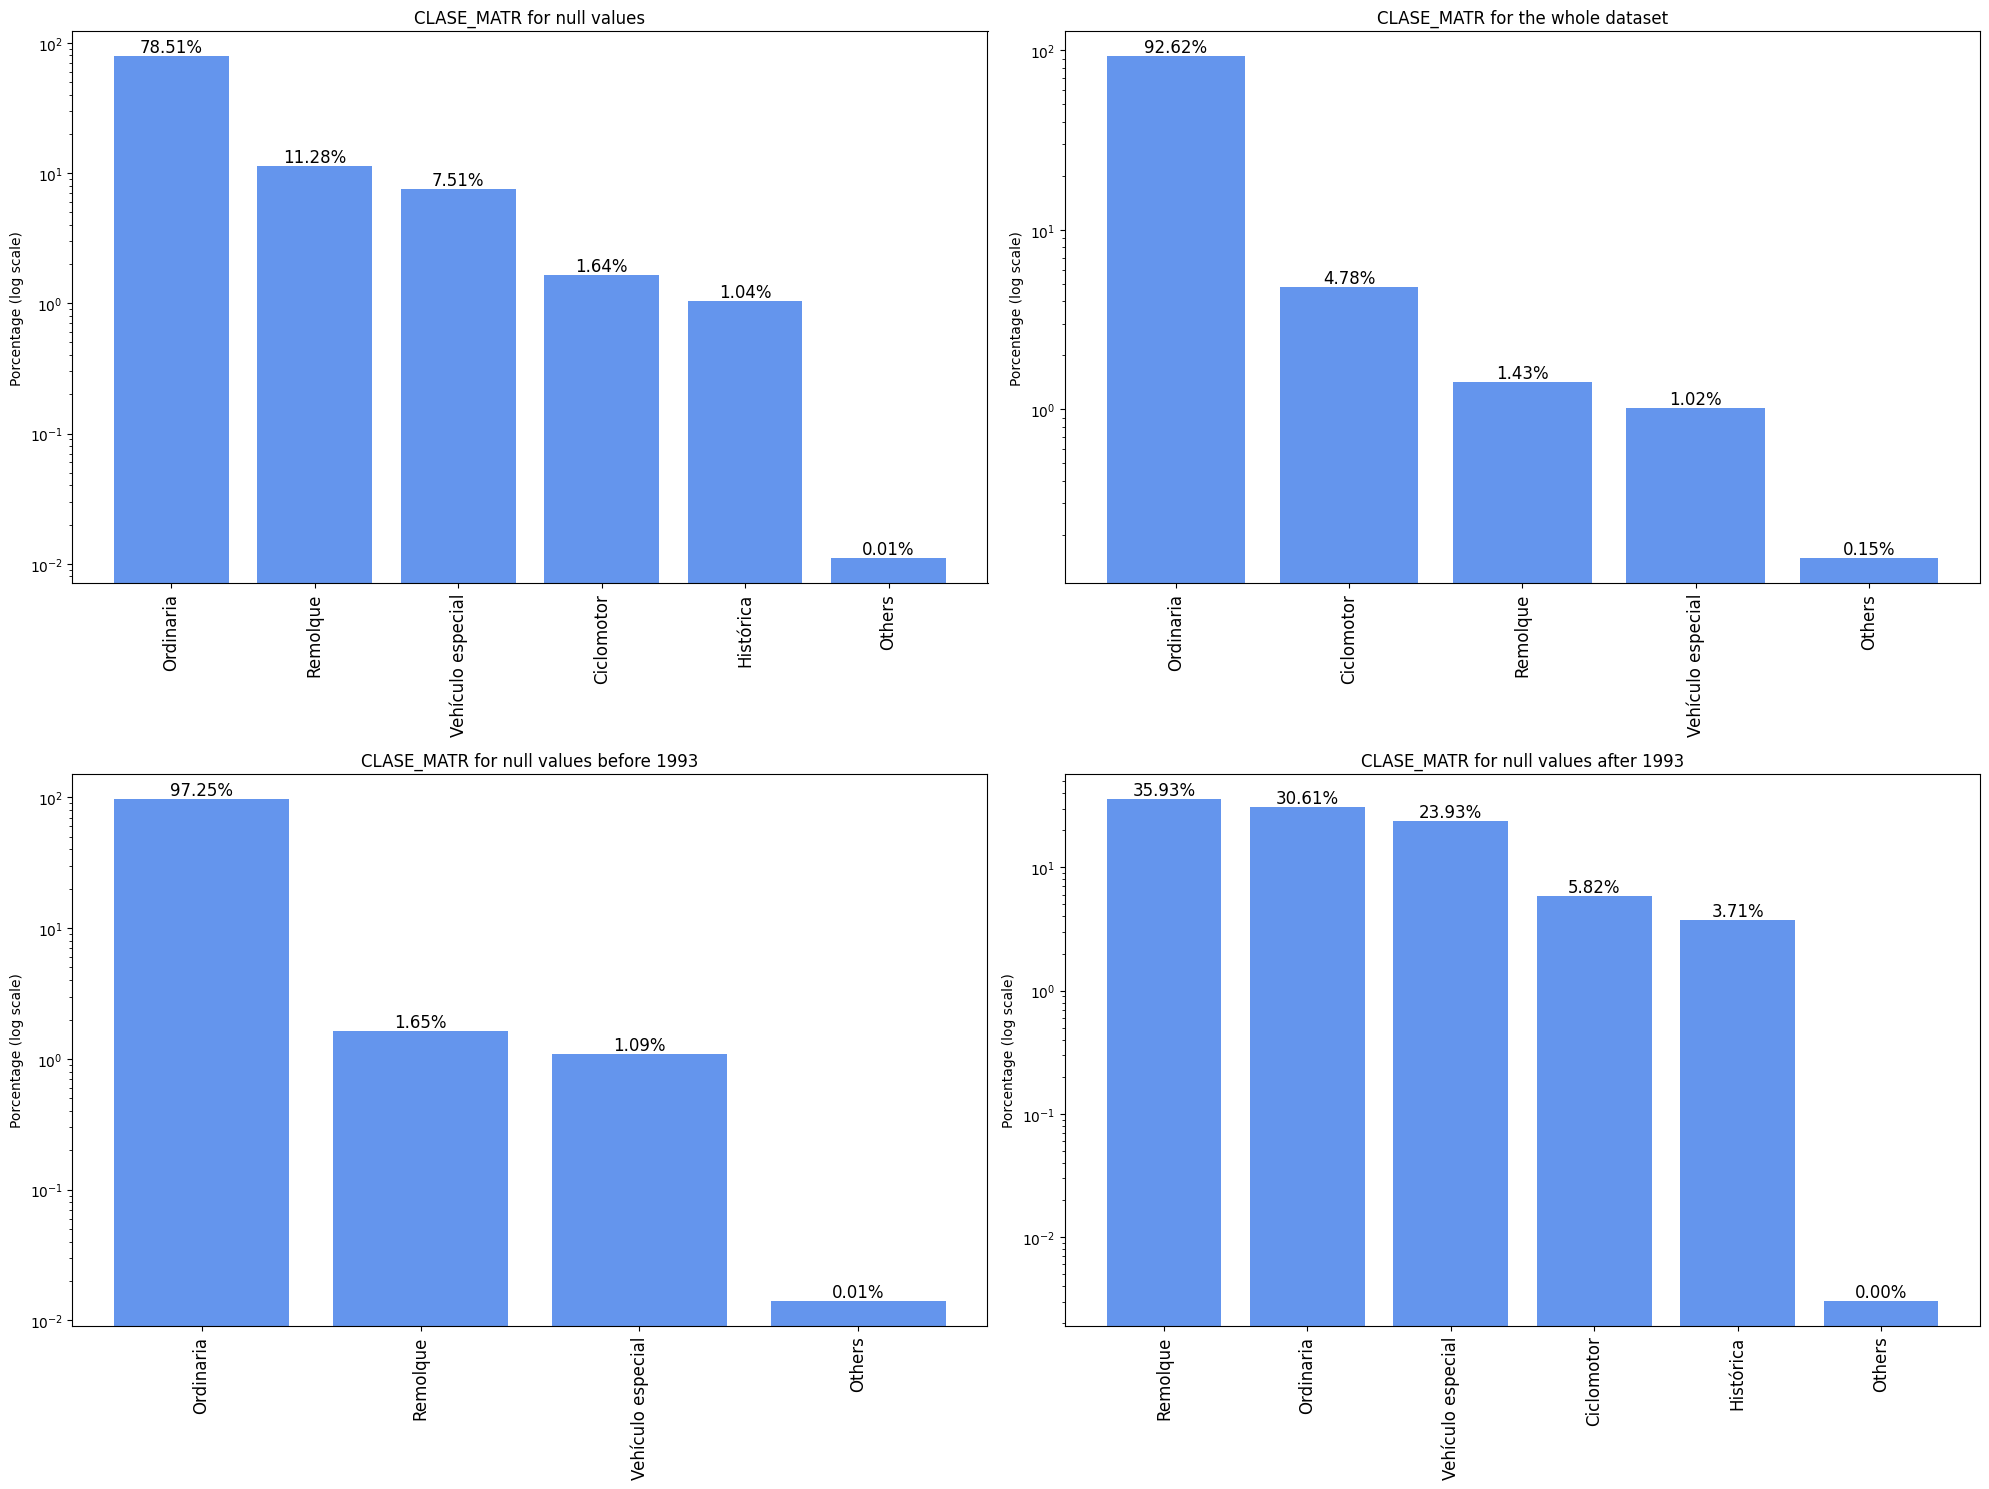

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'CLASE_MATR','CLASE_MATR for null values', axes[0,0])
bar_plot(complete_park, 'CLASE_MATR','CLASE_MATR for the whole dataset', axes[0,1])
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'CLASE_MATR',
         'CLASE_MATR for null values before 1993', axes[1,0])
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() > 1992), 'CLASE_MATR',
         'CLASE_MATR for null values after 1993', axes[1,1])

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_CLASSE_MATR.png')
plt.savefig(output_path)
plt.show()

#### EMISIONES_EURO related with SUBTIPO_DGT

In [ ]:
def bar_plot(df, col, title, ax=None,
             threshold=0.25, color='cornflowerblue',
             wrap_width=18,
             rotation=55,
             fontsize=12):

    import textwrap

    vc = df[col].value_counts().sort('count', descending=True)
    values, labels = vc['count'].to_list(), vc[col].to_list()
    labels = ['None' if l is None else l for l in labels]

    others = 0
    pct, lbl = [], []
    for v, l in zip(values, labels):
        p = 100 * v / sum(values)
        if p < threshold:
            others += p
        else:
            pct.append(p); lbl.append(l)
    if others: pct.append(others); lbl.append('Others')

    lbl_wrapped = ['\n'.join(textwrap.wrap(l, wrap_width)) for l in lbl]

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.bar(lbl_wrapped, pct, log=True, color=color)
    ax.set_ylabel('Percentage (log scale)')
    ax.set_title(title)
    ax.set_xticks(range(len(lbl_wrapped)))
    ax.set_xticklabels(lbl_wrapped, rotation=rotation, ha='right',
                       fontsize=fontsize)

    for b in bars:
        h = b.get_height()
        ax.text(b.get_x()+b.get_width()/2, h,
                f'{h:.2f}%', ha='center', va='bottom', fontsize=fontsize)

    ax.figure.subplots_adjust(bottom=0.3)


In [4]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")       
# Columns that were explored 
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW','TARA','PESO_MAX']

complete_park = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(columns)
complete_park = complete_park.collect()

complete_park = complete_park.with_columns(
    pl.col('CLASE_MATR').replace(mapping['CLASE_MATR']).alias("CLASE_MATR"),
    pl.col('SUBTIPO_DGT').replace(mapping['SUBTIPO_DGT']).alias("SUBTIPO_DGT"),
    pl.col('PROPULSION').replace(propulsion_mapping).alias("PROPULSION"))

null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_null())

not_null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_not_null())

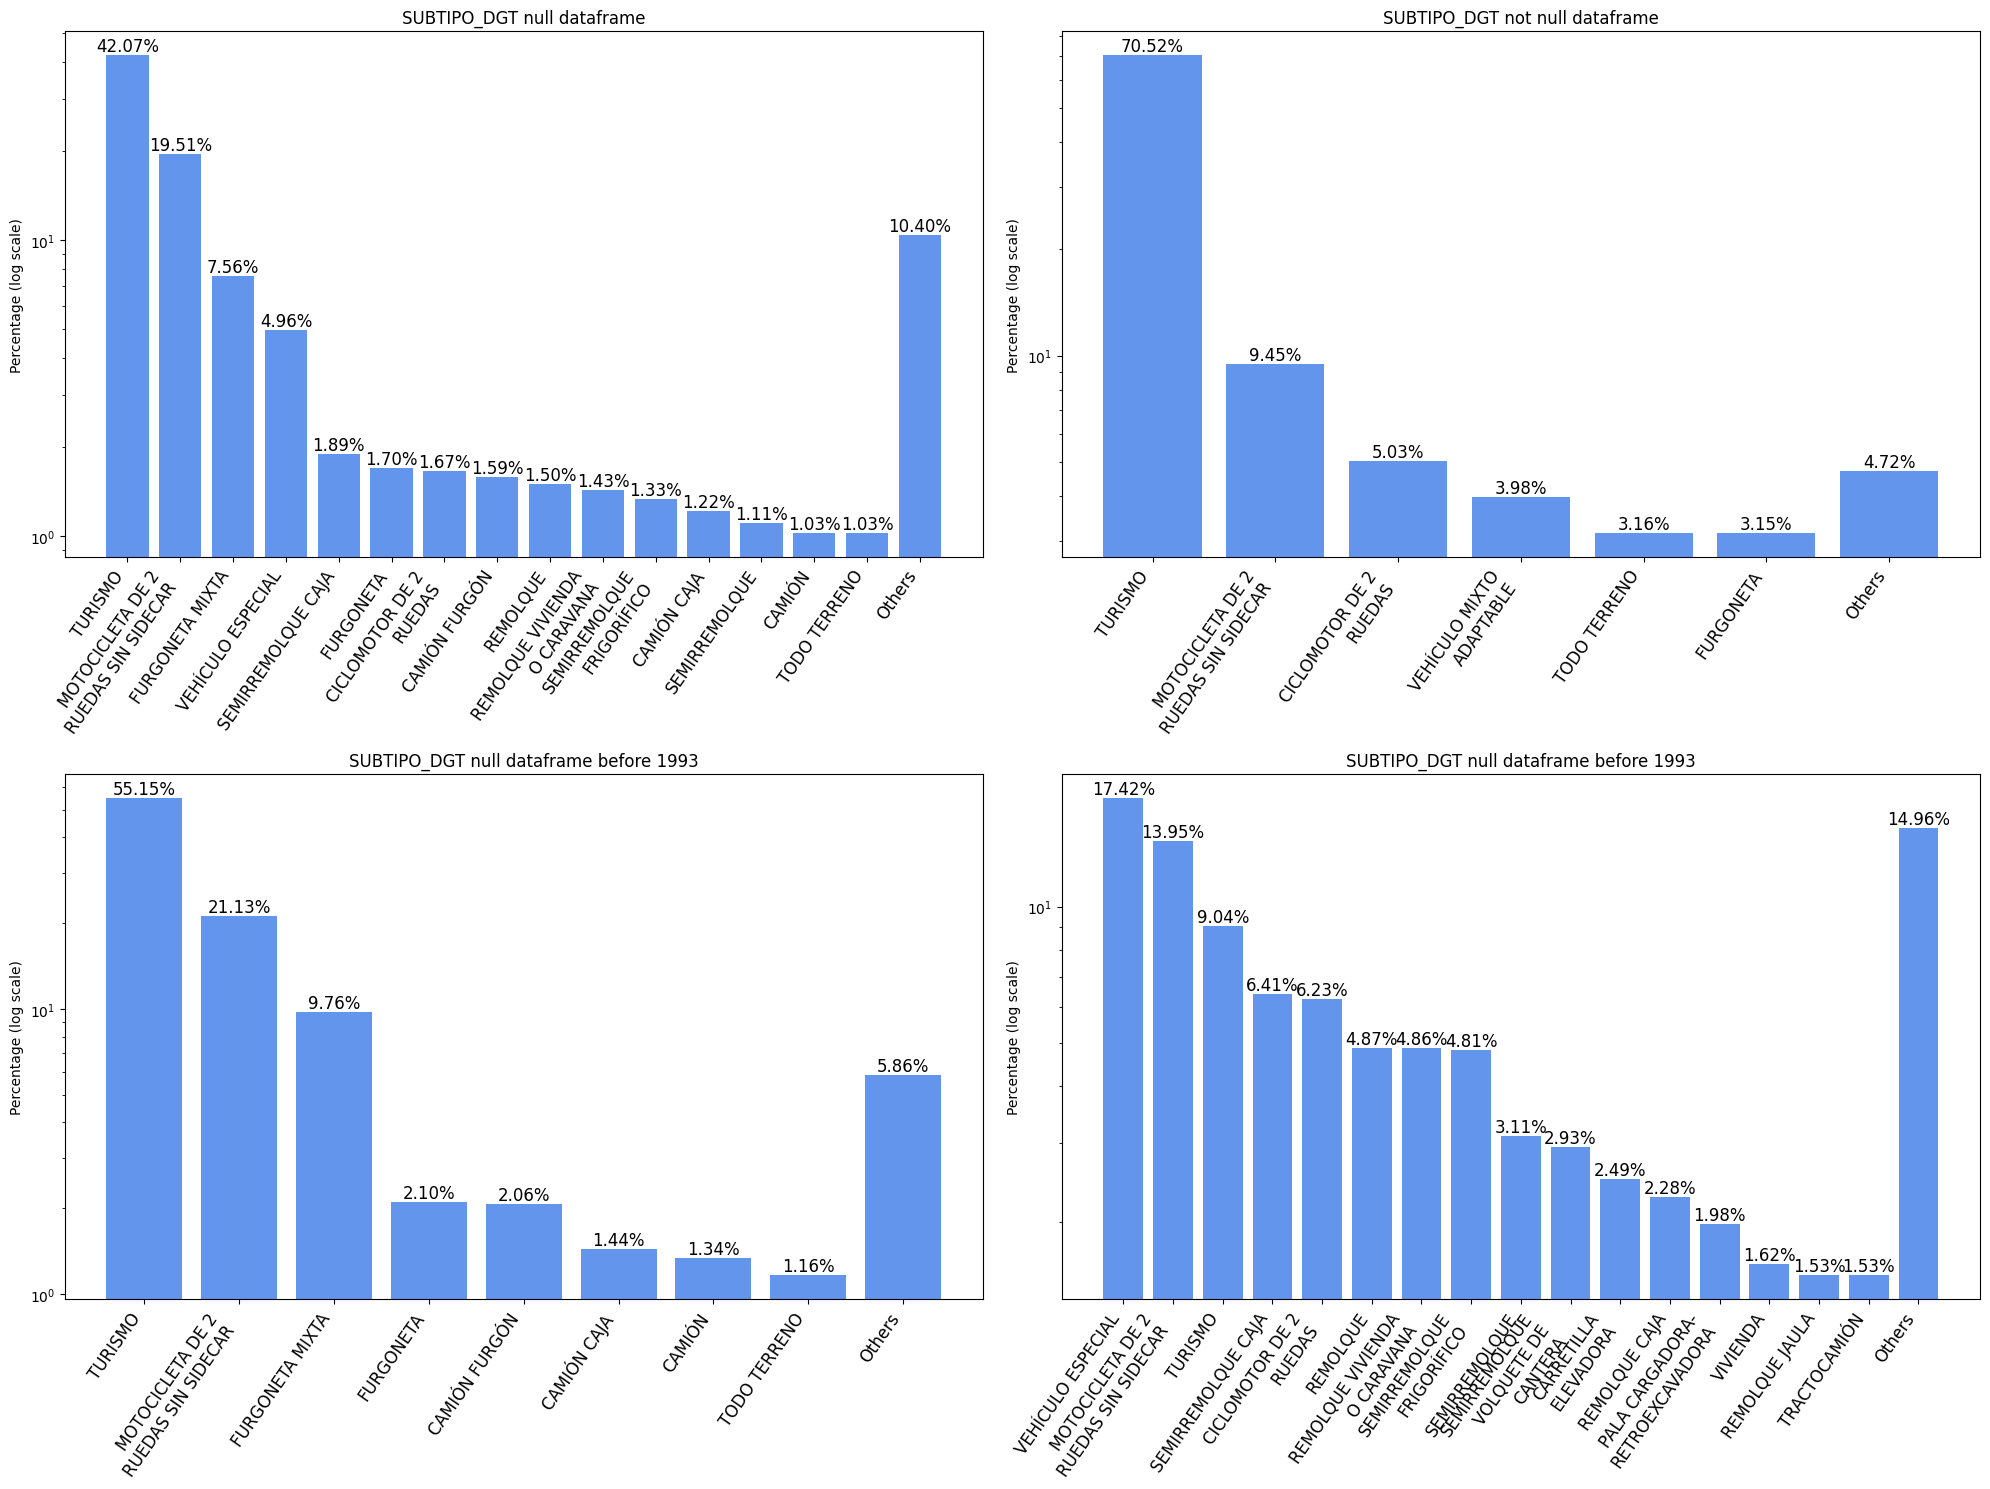

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'SUBTIPO_DGT','SUBTIPO_DGT null dataframe', axes[0,0],1)
bar_plot(not_null_dataframe, 'SUBTIPO_DGT','SUBTIPO_DGT not null dataframe', axes[0,1],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'SUBTIPO_DGT',
         'SUBTIPO_DGT null dataframe before 1993', axes[1,0],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() > 1993), 'SUBTIPO_DGT',
         'SUBTIPO_DGT null dataframe before 1993', axes[1,1],1.2)

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_SUB_TIPO.png')
plt.savefig(output_path)
plt.show()

#### EMISIONES_EURO related with PROPULSION

In [ ]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")       
# Columns that were explored 
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW','TARA','PESO_MAX']

complete_park = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(columns)
complete_park = complete_park.collect()

complete_park = complete_park.with_columns(
    pl.col('CLASE_MATR').replace(mapping['CLASE_MATR']).alias("CLASE_MATR"),
    pl.col('SUBTIPO_DGT').replace(mapping['SUBTIPO_DGT']).alias("SUBTIPO_DGT"),
    pl.col('PROPULSION').replace(propulsion_mapping).alias("PROPULSION"))

null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_null())

not_null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_not_null())

In [106]:
complete_park['PROPULSION'].value_counts().sort('count', descending=True)

PROPULSION,count
str,u32
"""DIES""",18476120
"""GAS""",18400600
null,557132
"""ELEC""",284854
"""GLP""",139957
…,…
"""H""",162
"""ETH""",77
"""BIOMET""",51


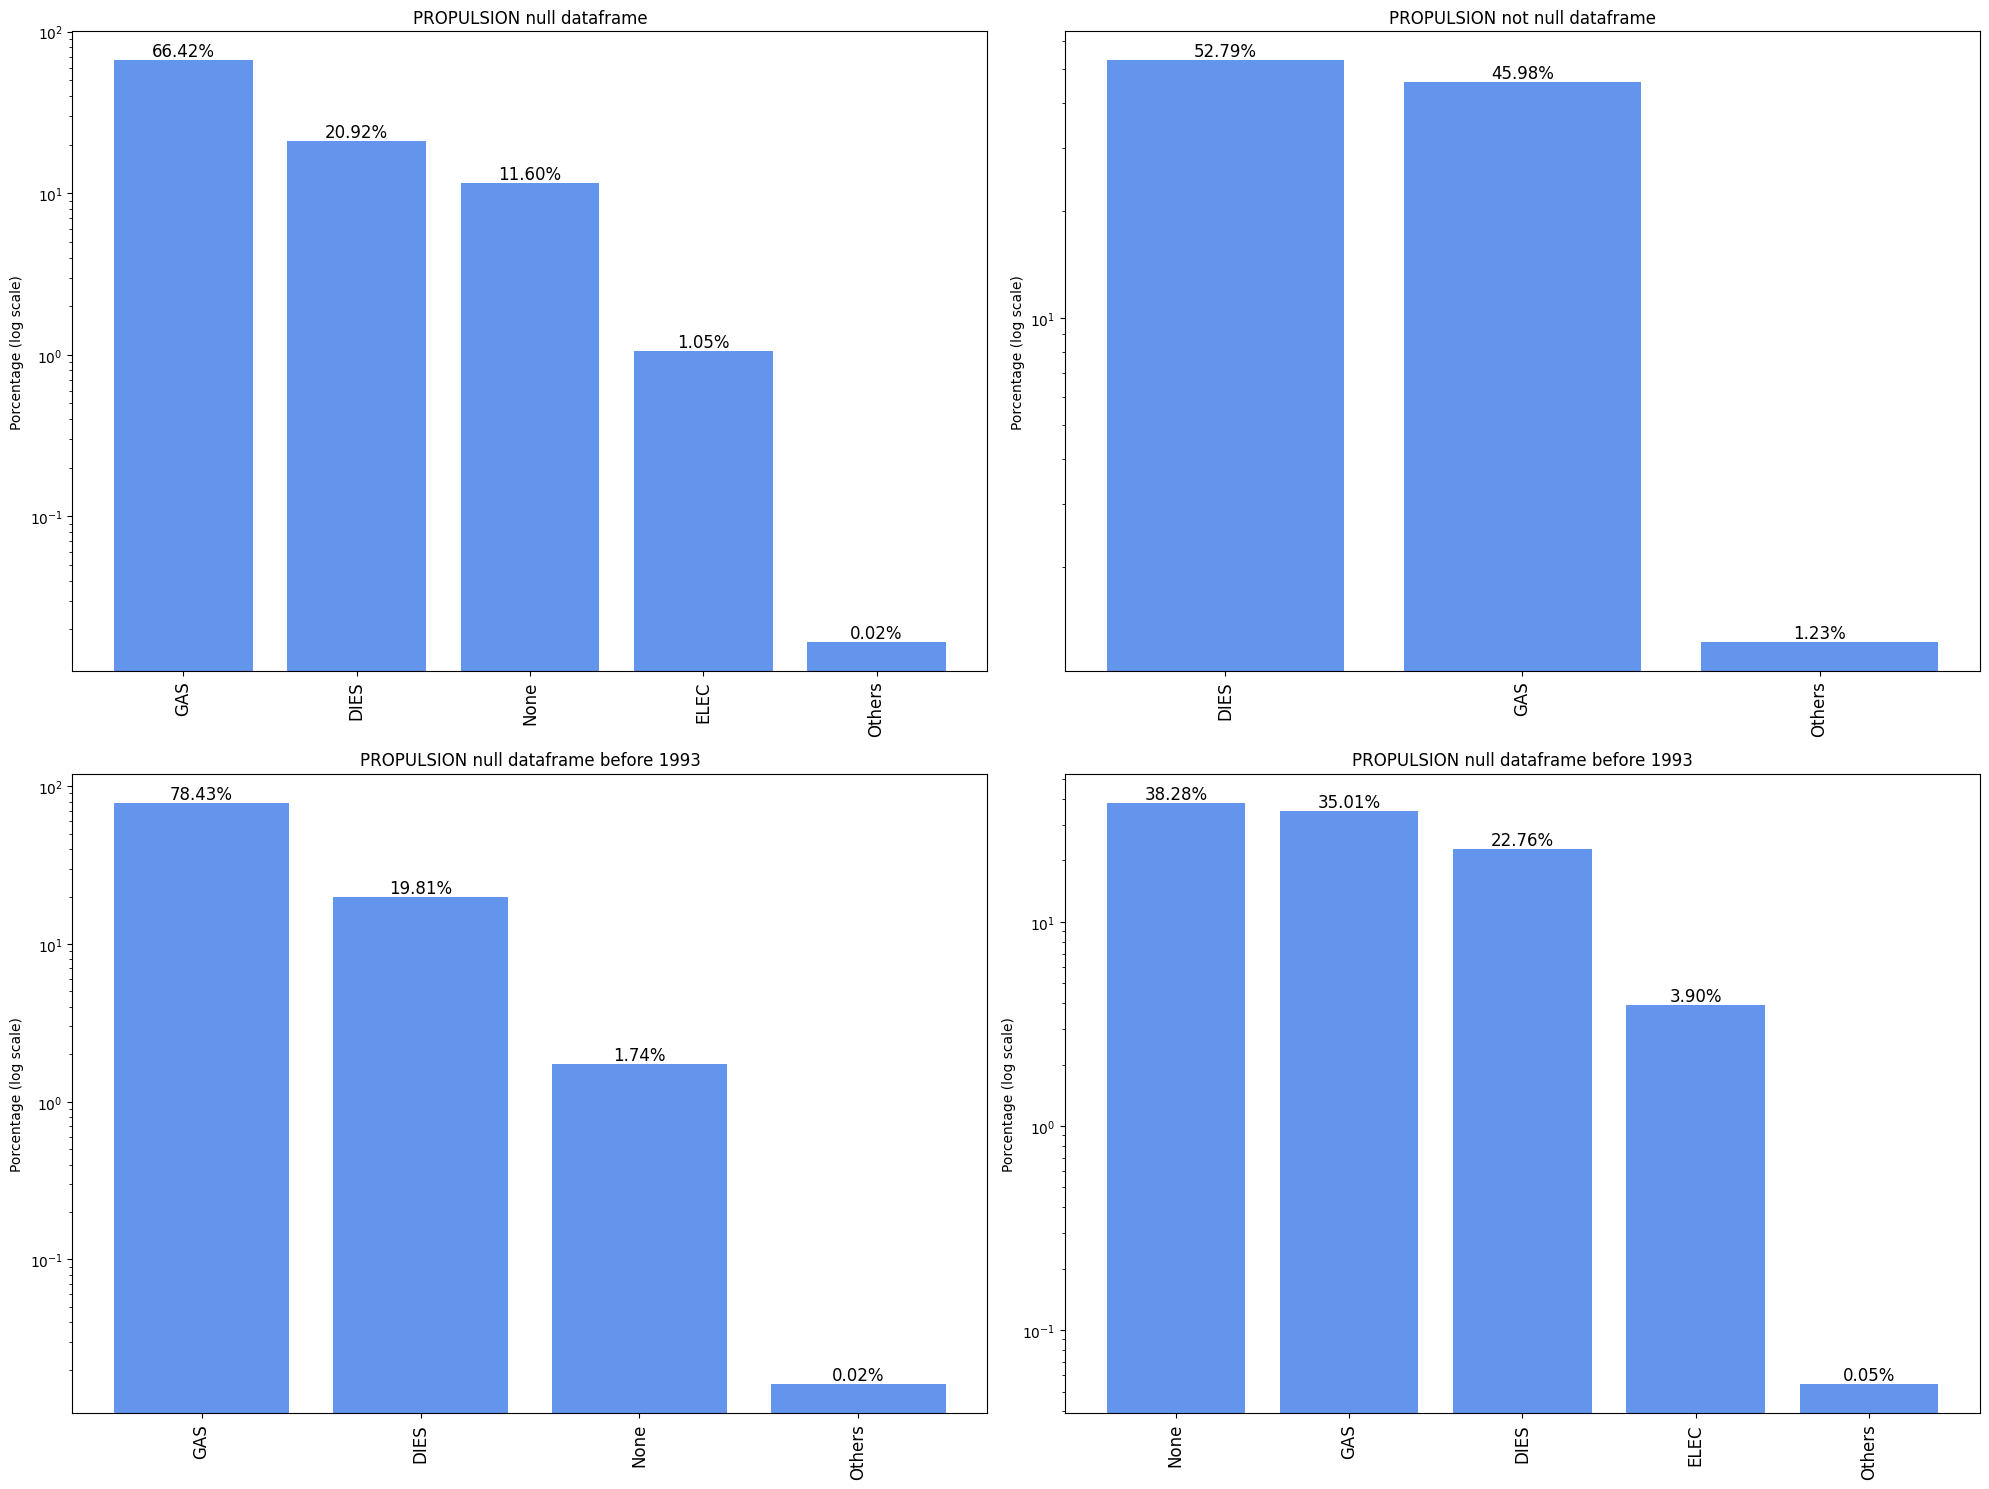

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

bar_plot(null_dataframe, 'PROPULSION','PROPULSION null dataframe', axes[0,0],1)
bar_plot(not_null_dataframe, 'PROPULSION','PROPULSION not null dataframe', axes[0,1],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() < 1993), 'PROPULSION',
         'PROPULSION null dataframe before 1993', axes[1,0],1)
bar_plot(null_dataframe.filter(pl.col('FECHA_MATR').dt.year() > 1993), 'PROPULSION',
         'PROPULSION null dataframe before 1993', axes[1,1],1.2)

plt.tight_layout()
output_path = os.path.join('..','Figures','EMISIONES_EURO_PROPULSION.png')
plt.savefig(output_path)
plt.show()

#### Categories inside EMISIONES_EURO

In [ ]:
path = os.path.join("..","Data", "DGT")
original_fleet_path = os.path.join(path,"Exact_fleet","mat_2023.txt")       
# Columns that were explored 
columns= ['FECHA_MATR','FECHA_PRIM_MATR','EMISIONES_CO2','EMISIONES_EURO',
          'SUBTIPO_DGT','PROPULSION','CLASE_MATR','ALIMENTACION','CATELECT',
          'CONSUMO','PROVINCIA_MATR','CILINDRADA','POTENCIA','KW','TARA','PESO_MAX']

complete_park = pl.scan_csv(original_fleet_path, separator='|', schema=types_fleet_original).select(columns)
complete_park = complete_park.collect()

complete_park = complete_park.with_columns(
    pl.col('CLASE_MATR').replace(mapping['CLASE_MATR']).alias("CLASE_MATR"),
    pl.col('SUBTIPO_DGT').replace(mapping['SUBTIPO_DGT']).alias("SUBTIPO_DGT"),
    pl.col('PROPULSION').replace(propulsion_mapping).alias("PROPULSION"))

null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_null())

not_null_dataframe = complete_park.filter(pl.col('EMISIONES_EURO').is_not_null())

In [ ]:
counts_euro = complete_park['EMISIONES_EURO'].value_counts().sort('count', descending=True)
total = counts_euro['count'].len()
mean = counts_euro.mean()['count'].item()
mean_counts = counts_euro.filter(pl.col('count')>mean)['count'].len()
print(f'Total number of categories present in the dataset: {total}')
print(f'Categories with more appearances than the average appearances: {mean_counts}')

Total number of categories present in the dataset: 179
Categories with more appearances than the average appearances: 16


In [141]:
m10= counts_euro.filter(pl.col('count')<10)['count'].len()
m100 = counts_euro.filter(pl.col('count')<100)['count'].len()
print(f'Categories present in the dataset with less tha 100 appeappearances: {m10}')
print(f'Categories present in the dataset with less tha 100 appeappearances: {m100}')


Categories present in the dataset with less tha 100 appeappearances: 59
Categories present in the dataset with less tha 100 appeappearances: 95


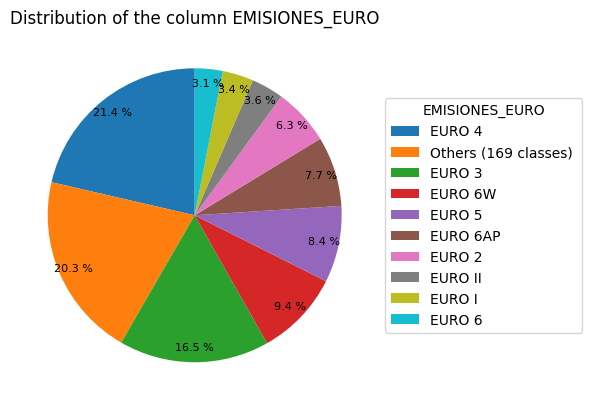

In [139]:
threshold_pct = 3.0
title         = "Distribution of the column EMISIONES_EURO"
output_path   = os.path.join("..", "Figures", "EMISIONES_EURO_DIST.png")

counts_euro = counts_euro.filter(pl.col('EMISIONES_EURO').is_not_null()).with_columns(pl.col("count").cast(pl.Int64))

counts_euro = counts_euro.with_columns((pl.col("count") / pl.sum("count") * 100).alias("pct"))

major = counts_euro.filter(pl.col("pct") >= threshold_pct)
minor = counts_euro.filter(pl.col("pct") <  threshold_pct)
others_count = minor['count'].len()

if minor.height > 0:
    others_row = pl.DataFrame({
        "EMISIONES_EURO": [f"Others ({others_count} classes) "],
        "count":          [minor["count"].sum()], 
        "pct":            [minor["pct"].sum()],
    })
    major = major.vstack(others_row)

major = major.sort("pct", descending=True)

labels = major["EMISIONES_EURO"].to_list()
sizes  = major["count"].to_list()

def autopct_fmt(p):
    return f"{p:.1f} %" if p >= threshold_pct else ""

fig, ax = plt.subplots(figsize=(6, 6))
wedges, *_ = ax.pie(
    sizes,
    startangle=90,
    autopct=autopct_fmt,
    pctdistance=0.9,
    textprops={"fontsize": 8}
)

ax.set_title(title)
ax.legend(
    wedges, labels,
    title="EMISIONES_EURO",
    loc="center left", bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()